### Check Analytical pipeline by comparing results with R outputs at both pixel and district levels

*Sources of differences in this notebook:*


**SPI computation**

- Rounding errors in CHIRPS-based SPI

- 1980-1981 season ignored for indexes related to second part of the season (and issued during first part) ignored in Python to harmonize with other indexes

- Calibration stop (end date of historical time series used in the gamma standardization): as we identify the index using its actual year in R and using the year of the beginning of season in Python, setting a fixed calibration stop to 2018/12/31 leads to different time ranges taken in the standardization for the different indices.

- Forecast-based SPI includes some differences related to the inclusion of 2022 / 2023 forecasts in the computation of probabilities of zeros in R (SPI AM particularly)

**Bias correction**

- Quantile function in bias correction (7 instead of 8: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html#r02de30f409d2-1)

- Interpolation between distributions of quantiles at the prediction step potentially done slightly differently

- Number of nearest neighbours at edges

**Spatial aggregation**

- Parts of some pixels ignored in Python: has quite an impact for districts like Marara that is made of only two pixels in Python

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%cd ../

from config.params import Params
from analytical import calculate_forecast_probabilities
from helper_fns import read_observations_locally, read_forecasts_locally, aggregate_by_district
from hip.analysis.ops._statistics import evaluate_roc_forecasts
from hip.analysis.analyses.drought import get_accumulation_periods

c:\Users\amine.barkaoui\OneDrive - World Food Programme\Documents\GitHub\anticipatory-action


INFO:root:Set disk cache path.


Prepare input data

In [ ]:
fc = read_forecasts_locally('data/MOZ/forecast/Moz_SAB_tp_ecmwf_01/*.nc')

In [3]:
obs = read_observations_locally(f"data/MOZ/chirps")

In [4]:
params = Params(iso='MOZ', index='SPI')
params.issue=1

In [7]:
triggers_df = pd.read_csv(f"data/{params.iso}/outputs/Plots/triggers.aa.python.spi.dryspell.2022.csv")
gdf = gpd.read_file(f"data/{params.iso}/shapefiles/moz_admbnda_2019_SHP/moz_admbnda_adm2_2019.shp")

In [8]:
accumulation_periods = get_accumulation_periods(
    fc, 
    params.start_season,
    params.end_season,
    params.min_index_period, 
    params.max_index_period
)
accumulation_periods
period = accumulation_periods['AM']

In [9]:
fc = fc.where(fc.time < np.datetime64('2022-07-01T12:00:00.000000000'), drop=True)

Test functions for ```calculate_forecast_probabilities``` and ```evaluate_forecast_probabilities```

In [10]:
params.year = 2022

In [3]:
def get_test_input(month="01"):
    np.random.seed(42)
    test_input_fc = xr.Dataset(
        data_vars=dict(
            tp=(["time", "ensemble", "longitude", "latitude"], np.random.rand(len(range(1993, 2022)) * 31, 5, 3, 3)),
        ),
        coords = dict(
            time=pd.concat([pd.Series(pd.date_range(f"{yyyy}-{month}-01", f"{yyyy}-{month}-31")) for yyyy in range(1993, 2022)]),
            ensemble=range(5),
            longitude=[-1, 0, 1],
            latitude=[-1, 0, 1],
        )
    )
    test_input_obs = xr.Dataset(
        data_vars=dict(precip=(["time", "longitude", "latitude"], np.random.rand(len(range(1993, 2022)) * 31, 3, 3))),
        coords = dict(
            time=pd.concat([pd.Series(pd.date_range(f"{yyyy}-{month}-01", f"{yyyy}-{month}-31")) for yyyy in range(1993, 2022)]),
            longitude=[-1, 0, 1],
            latitude=[-1, 0, 1],
        )
    )
    test_input_probas = xr.Dataset(
        data_vars=dict(tp=(["year"], np.random.rand(len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    np.random.seed(43)
    test_input_probas_bc = xr.Dataset(
        data_vars=dict(scen=(["year"], np.random.rand(len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    test_input_levels = xr.Dataset(
        data_vars=dict(precip=(["year"], np.random.randint(0, 2, len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    return test_input_fc, test_input_obs, test_input_probas, test_input_probas_bc, test_input_levels

In [ ]:
def test_calculate_forecast_probabilities():
    np.random.seed(42)
    test_input_fc1, test_input_obs1, _, _, _ = get_test_input("01")
    probabilities_a, bc_a, _, levels_obs_a = calculate_forecast_probabilities(test_input_fc1, test_input_obs1, params, (1), 1) 
    probabilities_b, bc_b, _, levels_obs_b = calculate_forecast_probabilities(test_input_fc1, test_input_obs1, params, (1), 12) 
    
    ref_probas_month1 = xr.DataArray(
        np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.13333333, 0.2, 0.2, 0.4, 0.2, 0., 0.06666667, 0., 0.2, 0.33333333, 0., 0.2, 0.2, 0.13333333, 0.2, 0.6, 0, 0.6, 0.33333333, 0.2, 0.2, 0.26666667, 0.13333333, 0.]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_bc_month1_issue1 = xr.DataArray(
        np.array([0.2, 0.26666667, 0.2, 0.33333333, 0.2, 0.06666667, 0.26666667, 0.2, 0.4, 0.26666667, 0., 0.06666667, 0., 0.2, 0.26666667, 0.06666667, 0.2, 0.13333333, 0.2, 0.2, 0.73333333, 0., 0.6, 0.33333333, 0.2, 0.2, 0.26666667, 0.2, 0.]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_bc_month1_issue12 = xr.DataArray(
        np.array([0.13333333, 0.26666667, 0.2, 0.13333333, 0.2, 0.2 , 0.26666667, 0.2 , 0.4, 0.26666667, 0., 0.06666667, 0., 0.2, 0.4, 0., 0.2, 0.2, 0.26666667, 0.2, 0.66666667, 0., 0.6, 0.46666667, 0.2, 0.2, 0.33333333, 0.2, 0]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_obs_month1 = xr.DataArray(
        np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.66666667, 0, 0, 1, 0, 1, 0.33333333, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.33333333]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))

    xr.testing.assert_allclose(probabilities_a.sel(latitude=0, longitude=0).mean('category').tp, ref_probas_month1)
    xr.testing.assert_allclose(probabilities_b.sel(latitude=0, longitude=0).mean('category').tp, ref_probas_month1)

    xr.testing.assert_allclose(bc_a.sel(latitude=0, longitude=0).mean('category').scen, ref_bc_month1_issue1)
    xr.testing.assert_allclose(bc_b.sel(latitude=0, longitude=0).mean('category').scen, ref_bc_month1_issue12)
    
    xr.testing.assert_allclose(levels_obs_a.sel(latitude=0, longitude=0).mean('category').precip, ref_obs_month1)
    xr.testing.assert_allclose(levels_obs_b.sel(latitude=0, longitude=0).mean('category').precip, ref_obs_month1)

    print("\nFORECASTS PROBABILITIES TESTS PASSED")
ref_probas_month1_issue1 = test_calculate_forecast_probabilities()

INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed accumulation
INFO:root:Completed anomaly



FORECASTS PROBABILITIES TESTS PASSED


In [8]:
def test_evaluate_forecast_probabilities():
    _, _, test_probas, test_probas_bc, test_obs_levels = get_test_input()
    test_auc, test_auc_bc = evaluate_roc_forecasts(test_obs_levels.precip, test_probas.tp, test_probas_bc.scen)

    xr.testing.assert_allclose(test_auc, xr.DataArray(0.45192308))
    xr.testing.assert_allclose(test_auc_bc, xr.DataArray(0.19230769))

    print("\nFORECASTS VERIFICATION TESTS PASSED")

test_evaluate_forecast_probabilities()


FORECASTS VERIFICATION TESTS PASSED


Get Python probabilities and AUC

In [23]:
probabilities, probabilities_bc, obs_values, levels_obs = calculate_forecast_probabilities(fc, obs, params, period, params.issue) 

INFO:root:Completed accumulation
INFO:root:Completed anomaly
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\aa-env\lib\site-packages\xclim\sdba\utils.py:317: RuntimeWarning: All-NaN slice encountered in interp_on_quantiles
  warn(
c:\Users\amine.barkaoui\AppData\Local\miniconda3\envs\

In [24]:
auc, auc_bc = evaluate_roc_forecasts(levels_obs.precip, probabilities.tp, probabilities_bc.scen)

In [25]:
# Aggregate AUC by district
auc_districts = aggregate_by_district(auc, gdf, params)

In [26]:
auc_bc_districts = aggregate_by_district(auc_bc, gdf, params)

### AUC comparison at the pixel level (for one index and one issue month)

In [27]:
def plot_hist(comparison, title, xlabel, xmin, xmax, s=1, mask_text=False):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (6,4))

    quant_5, quant_25, quant_50, quant_75, quant_95 = comparison.difference.quantile(0.05), comparison.difference.quantile(0.25), comparison.difference.quantile(0.5), comparison.difference.quantile(0.75), comparison.difference.quantile(0.95)

    # [quantile, opacity, length]
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    comparison.difference.plot(kind='hist', density = True, alpha = 0.65, bins=200)
    comparison.difference.plot(kind='kde')

    # Plot the lines with a loop
    import matplotlib.pyplot as plt
    for i in quants: plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax) 

    # Y
    ax.set_yticklabels([])
    ax.set_ylabel("")

    if not(mask_text):
        plt.text(quant_5-.01, 0.15 * s, "5th", size = 10, alpha = 0.8)
        plt.text(quant_25-.013, 0.27 * s, "25th", size = 11, alpha = 0.85)
        plt.text(quant_50-.013, 0.33 * s, "50th", size = 12, alpha = 1)
        plt.text(quant_75-.013, 0.39 * s, "75th", size = 11, alpha = 0.85)
        plt.text(quant_95-.025, 0.47 * s, "95th Percentile", size = 10, alpha =.8)

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

**Without bias correction**

In [16]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/raw/issued10.AUROC.csv')[['V1', 'V2', 'SPI ON']]
ref.columns = ['longitude', 'latitude', 'auroc_severo']

auc_df = auc.to_dataframe().reset_index()
auc_df = auc_df.loc[auc_df.category == 'Severo'].drop('category', axis=1)

compare_auc = auc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc['difference'] = compare_auc['histogram_observations_forecasts'] - compare_auc['auroc_severo']

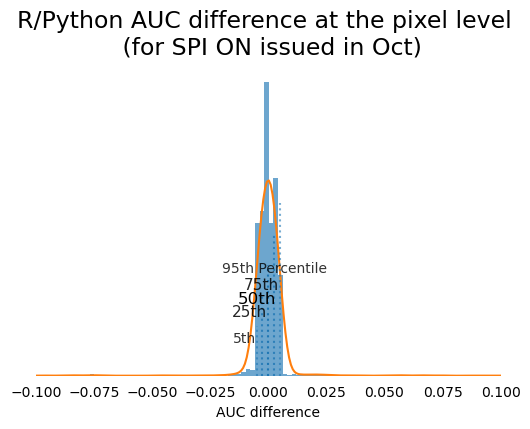

In [278]:
plot_hist(compare_auc, title="R/Python AUC difference at the pixel level \n (for SPI ON issued in Oct)", xlabel="AUC difference", xmin=-.10, xmax=.10, s=100)

*Sources of differences related to the above plot:*

- Rounding errors in CHIRPS-based SPI

In [29]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/raw/issued12.AUROC.csv')[['V1', 'V2', 'SPI FM']]
ref.columns = ['longitude', 'latitude', 'auroc_severo']

auc_df = auc.to_dataframe().reset_index()
auc_df = auc_df.loc[auc_df.category == 'Severo'].drop('category', axis=1)

compare_auc = auc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc['difference'] = compare_auc['histogram_observations_forecasts'] - compare_auc['auroc_severo']

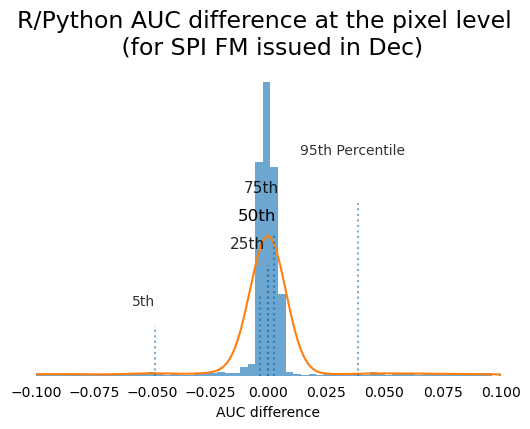

In [33]:
plot_hist(compare_auc, title="R/Python AUC difference at the pixel level \n (for SPI FM issued in Dec)", xlabel="AUC difference", xmin=-.10, xmax=.10, s=150)

*Sources of differences related to the above plot:*

**SPI computation**

- Rounding errors in CHIRPS-based SPI

- Index FM 1981 (1980-1981 season) ignored in Python to harmonize with other indexes

- Calibration stop (end date of historical time series used in the gamma standardization): as we identify the index using its actual year in R and using the year of the beginning of season in Python, setting a fixed calibration stop to 2018/12/31 leads to different time ranges taken in the standardization for the different indices.

In [28]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/raw/issued01.AUROC.csv')[['V1', 'V2', 'SPI AM']]
ref.columns = ['longitude', 'latitude', 'auroc_severo']

auc_df = auc.to_dataframe().reset_index()
auc_df = auc_df.loc[auc_df.category == 'Severo'].drop('category', axis=1)

compare_auc = auc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc['difference'] = compare_auc['histogram_observations_forecasts'] - compare_auc['auroc_severo']

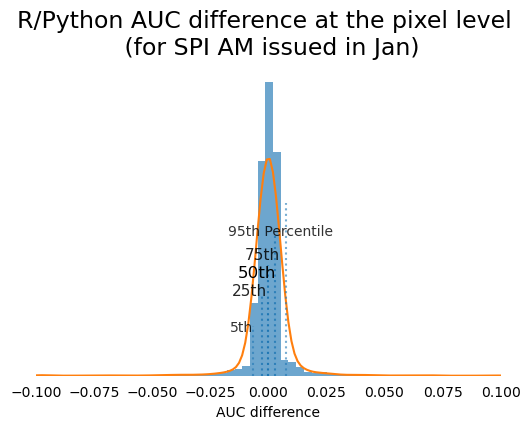

In [18]:
plot_hist(compare_auc, title="R/Python AUC difference at the pixel level \n (for SPI AM issued in Jan)", xlabel="AUC difference", xmin=-.10, xmax=.10, s=100)

*Sources of differences related to the above plot:*

**SPI computation**

- Rouding errors in CHIRPS-based SPI

- Forecast-based SPI includes some differences related to the inclusion of 2022 / 2023 forecasts in the computation of probabilities of zeros in R

**With bias correction**

In [279]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/bc/issued10.Empirical_BCSPIENSO.k_AUROC.csv')[['V1', 'V2', 'SPI ON']]
ref.columns = ['longitude', 'latitude', 'auroc_bc_severo']

auc_bc_df = auc_bc.to_dataframe().reset_index()
auc_bc_df = auc_bc_df.loc[auc_bc_df.category == 'Severo'].drop('category', axis=1)

compare_auc_bc = auc_bc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc_bc['difference'] = compare_auc_bc['histogram_observations_forecasts'] - compare_auc_bc['auroc_bc_severo']

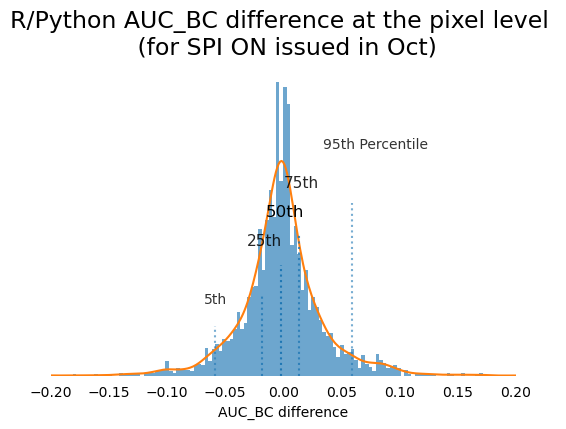

In [280]:
plot_hist(compare_auc_bc, title="R/Python AUC_BC difference at the pixel level \n (for SPI ON issued in Oct)", xlabel="AUC_BC difference", xmin=-.2, xmax=.2, s=40)

*Sources of differences related to the above plot:*

**SPI computation** (amplified during bias correction phase)


- Rounding errors in CHIRPS-based SPI

**Bias correction**

- Quantile function in bias correction (7 instead of 8: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html#r02de30f409d2-1)

- Interpolation between distributions of quantiles at the prediction step

In [272]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/bc/issued12.Empirical_BCSPIENSO.k_AUROC.csv')[['V1', 'V2', 'SPI FM']]
ref.columns = ['longitude', 'latitude', 'auroc_bc_severo']

auc_bc_df = auc_bc.to_dataframe().reset_index()
auc_bc_df = auc_bc_df.loc[auc_bc_df.category == 'Severo'].drop('category', axis=1)

compare_auc_bc = auc_bc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc_bc['difference'] = compare_auc_bc['histogram_observations_forecasts'] - compare_auc_bc['auroc_bc_severo']

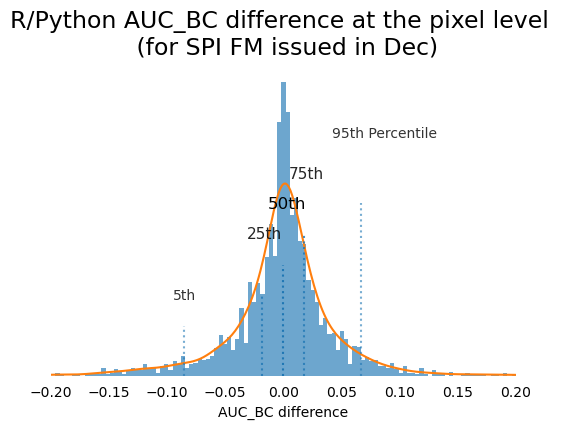

In [273]:
plot_hist(compare_auc_bc, title="R/Python AUC_BC difference at the pixel level \n (for SPI FM issued in Dec)", xlabel="AUC_BC difference", xmin=-.2, xmax=.2, s=40)

*Sources of differences related to the above plot:*

**SPI computation** (amplified during bias correction phase)

- Rounding errors in CHIRPS-based SPI

- Index FM 1981 (1980-1981 season) ignored in Python to harmonize with other indexes

- Calibration stop (end date of historical time series used in the gamma standardization): as we identify the index using its actual year in R and using the year of the beginning of season in Python, setting a fixed calibration stop to 2018/12/31 leads to different time ranges taken in the standardization for the different indices.


**Bias correction**

- Quantile function in bias correction (7 instead of 8: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html#r02de30f409d2-1)

- Interpolation between distributions of quantiles at the prediction step

In [30]:
ref = pd.read_csv('data/MOZ/R_results_for_comparison/bc/issued01.Empirical_BCSPIENSO.k_AUROC.csv')[['V1', 'V2', 'SPI AM']]
ref.columns = ['longitude', 'latitude', 'auroc_bc_severo']

auc_bc_df = auc_bc.to_dataframe().reset_index()
auc_bc_df = auc_bc_df.loc[auc_bc_df.category == 'Severo'].drop('category', axis=1)

compare_auc_bc = auc_bc_df.set_index(['latitude','longitude']).join(ref.set_index(['latitude','longitude']))
compare_auc_bc['difference'] = compare_auc_bc['histogram_observations_forecasts'] - compare_auc_bc['auroc_bc_severo']

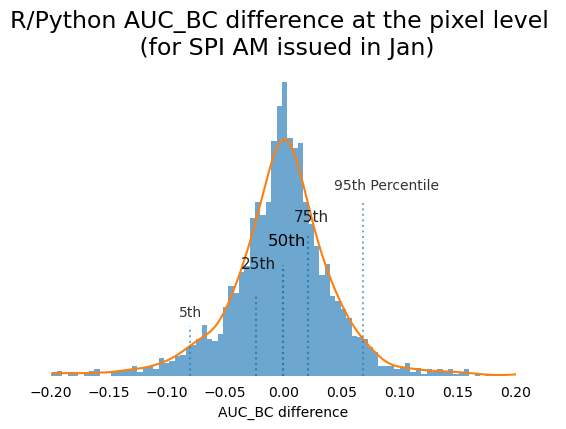

In [364]:
plot_hist(compare_auc_bc, title="R/Python AUC_BC difference at the pixel level \n (for SPI AM issued in Jan)", xlabel="AUC_BC difference", xmin=-.2, xmax=.2, s=20)

*Sources of differences related to the above plot:*

**SPI computation** (amplified during the bias correction phase)

- Rounding errors in CHIRPS-based SPI

- Forecast-based SPI includes some differences related to the inclusion of 2022 / 2023 forecasts in the computation of probabilities of zeros in R

**Bias correction**

- Quantile function in bias correction (7 instead of 8: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html#r02de30f409d2-1)

- Interpolation between distributions of quantiles at the prediction step

- Number of nearest neighbours at edges (set to 5 or even 3 at corners in Python)

### Comparison on the full output at the district level

In [63]:
fbfR = pd.read_csv('data/MOZ/outputs/Districts_FbF/spi/fbf.districts.roc_2023_2.txt', sep=' ')
fbfR['Index'] = [f"{i.split('.')[0]} {i.split('.')[1]}" for i in fbfR['Index'].values]
fbfR.columns = ['Index', 'AUROC_R', 'district', 'issue', 'category', 'BC_Rdecision']
fbfR

,Index,AUROC_R,district,issue,category,BC_Rdecision
0,SPI AM,0.635392,Alto_Molocue,1,Leve,no
1,SPI AM,0.604309,Alto_Molocue,1,Moderado,no
2,SPI AM,0.525686,Alto_Molocue,1,Normal,no
3,SPI AM,0.599837,Alto_Molocue,1,Severo,no
4,SPI AM,0.483136,Ancuabe,1,Leve,yes_ENSO
...,...,...,...,...,...,...
46918,SPI AM,0.576779,Zavala,12,Moderado,no
46919,SPI AM,0.569368,Zavala,12,Severo,no
46920,SPI AM,0.542854,Zumbu,12,Leve,yes_ENSO
46921,SPI AM,0.542013,Zumbu,12,Moderado,yes_ENSO


In [126]:
fbfP = pd.read_csv('data/MOZ/outputs/Districts_FbF/spi/fbf.districts.roc.spi.finaaal.2022.txt')
fbfP

,district,category,AUC_best,BC,Index,issue
0,Chiure,Severo,0.687272,1,SPI ON,5
1,Chiure,Moderado,0.654013,1,SPI ON,5
2,Chiure,Leve,0.573892,1,SPI ON,5
3,Chibuto,Severo,0.699521,0,SPI ON,5
4,Chibuto,Moderado,0.720069,0,SPI ON,5
...,...,...,...,...,...,...
2239,Changara,Moderado,0.774912,0,SPI MAM,2
2240,Changara,Leve,0.728277,0,SPI MAM,2
2241,Marara,Severo,0.855556,0,SPI MAM,2
2242,Marara,Moderado,0.808243,0,SPI MAM,2


Ratio of bias-corrected values in the final output

In [127]:
# Ratio of cases using Bias Correction
fbfP.BC.sum() / len(fbfP)

0.20053475935828877

Histogram of difference between full outputs

In [128]:
comparison = fbfP.set_index(['district', 'category', 'Index', 'issue']).join(fbfR.set_index(['district', 'category', 'Index', 'issue'])).reset_index()

In [129]:
comparison['difference'] = comparison.AUC_best - comparison.AUROC_R

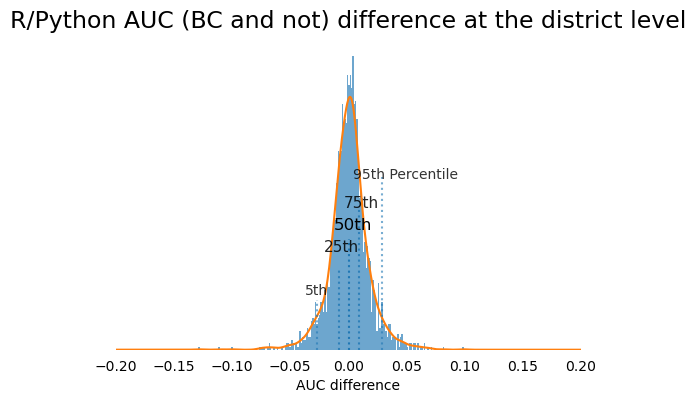

In [130]:
plot_hist(comparison, title="R/Python AUC (BC and not) difference at the district level", xlabel="AUC difference", xmin=-.2, xmax=.2, s=45)

This plot shows some differences, that are partly related to the different points detailed above, but also caused here by the spatial aggregation method. In R, the clipping function takes the ratio of all pixels touched by the polygon falling within the area. In Python, it only considers the pixels falling entirely within the area shape. Improving spatial aggregation in Python is therefore a potential way of improving the results. 

### Difference (Python - R) on the full output by category / district / index / issue

Text(0.5, 0.98, 'SEVERE CATEGORY')

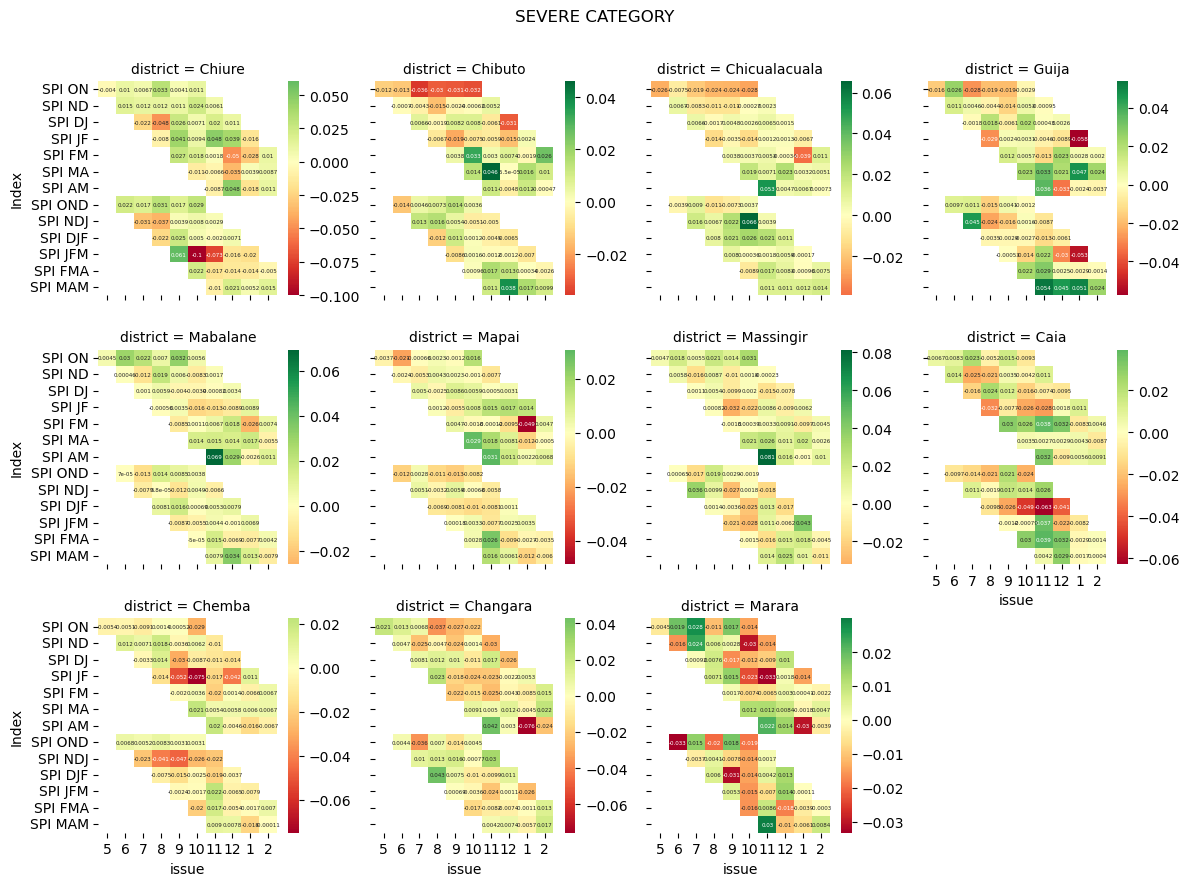

In [131]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(comparison.loc[(comparison.category=='Severo')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('SEVERE CATEGORY')

Text(0.5, 0.98, 'MODERATE CATEGORY')

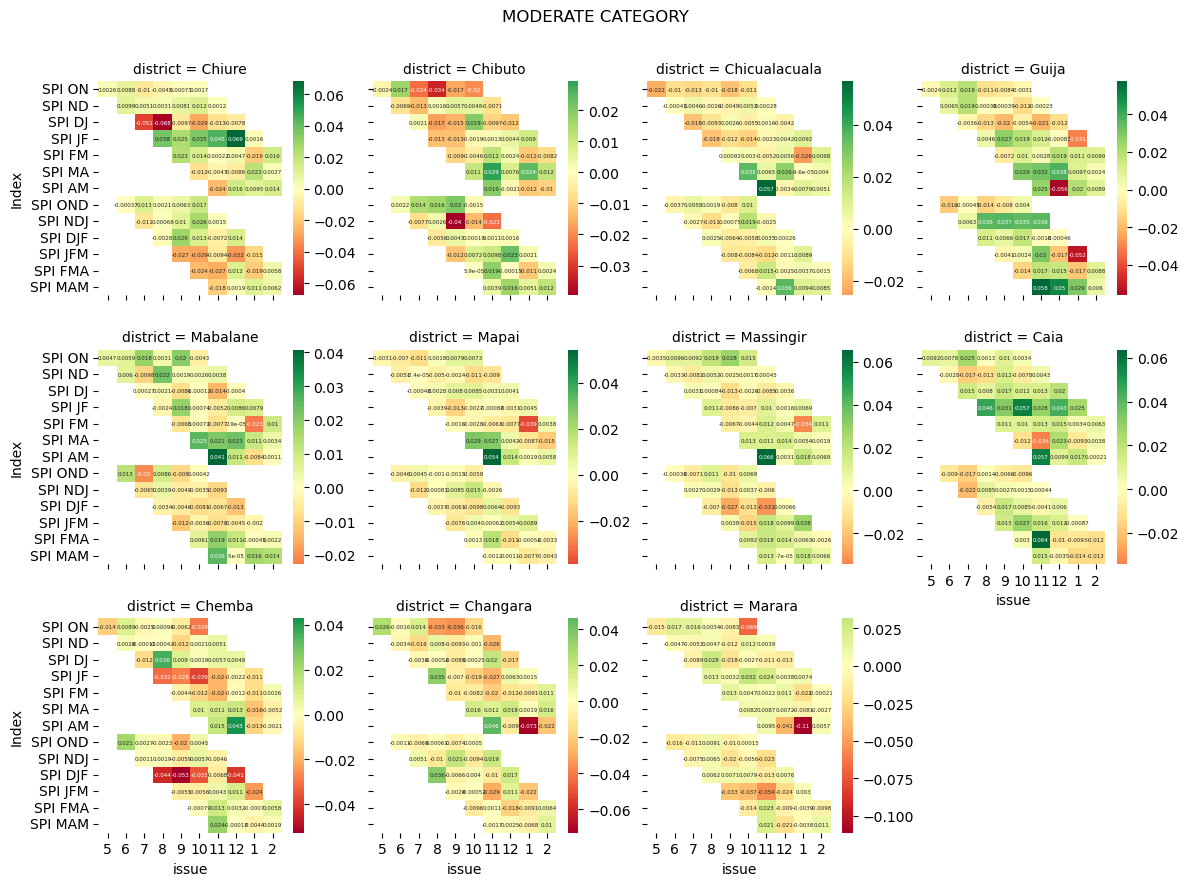

In [132]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Moderado')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MODERATE CATEGORY')

Text(0.5, 0.98, 'MILD CATEGORY')

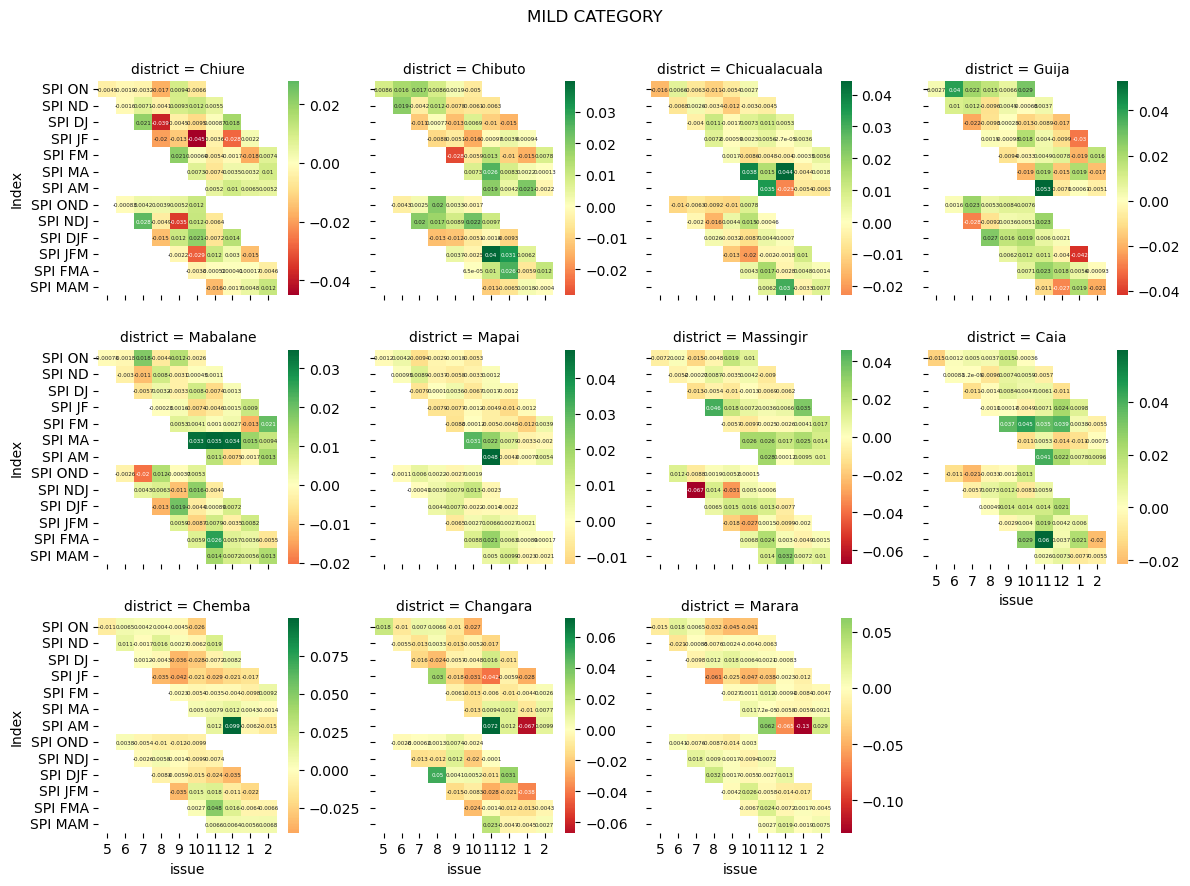

In [133]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Leve')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MILD CATEGORY')

### Visualisation of differences for each pair of variables to highlight any systematic errors in the Python script

**Average difference**

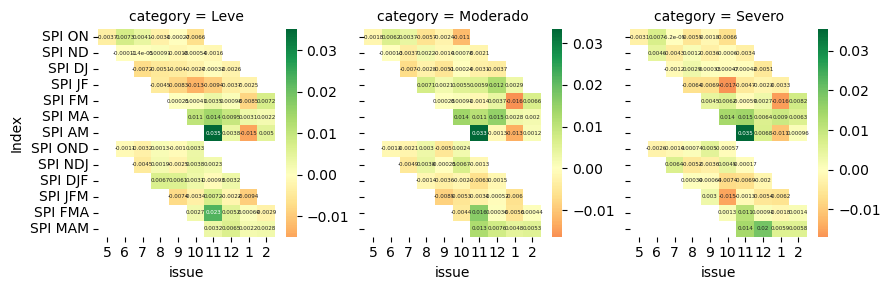

In [134]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'Index', 'category']).mean('district').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

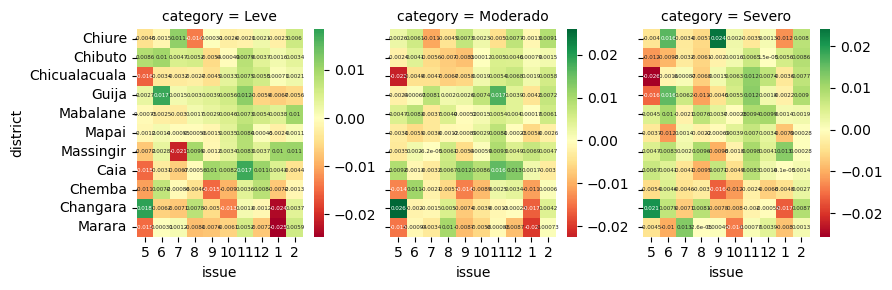

In [135]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'district', 'category']).mean('Index').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

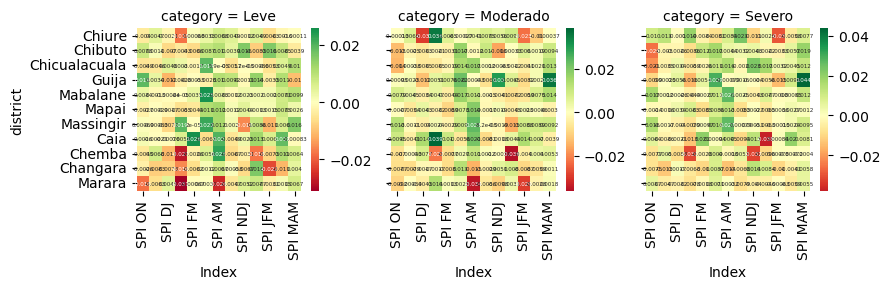

In [136]:
x_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="Index", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['Index', 'district', 'category']).mean('issue').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

**RMSE**

In [137]:
comparison['difference2'] = comparison.difference ** 2

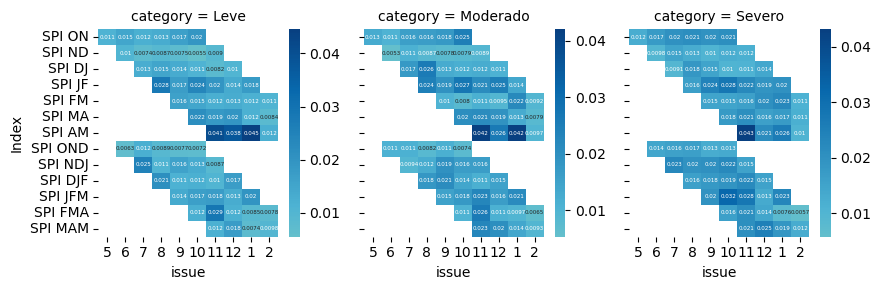

In [138]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference2")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'Index', 'category']).mean('district').apply(np.sqrt).reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='GnBu', center=0)

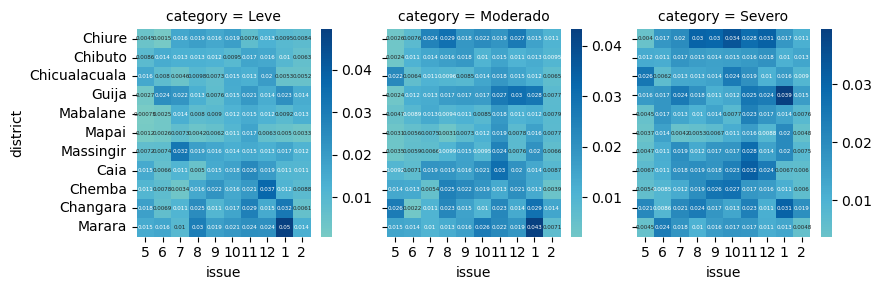

In [139]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="issue", values="difference2")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'district', 'category']).mean('Index').apply(np.sqrt).reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='GnBu', center=0)

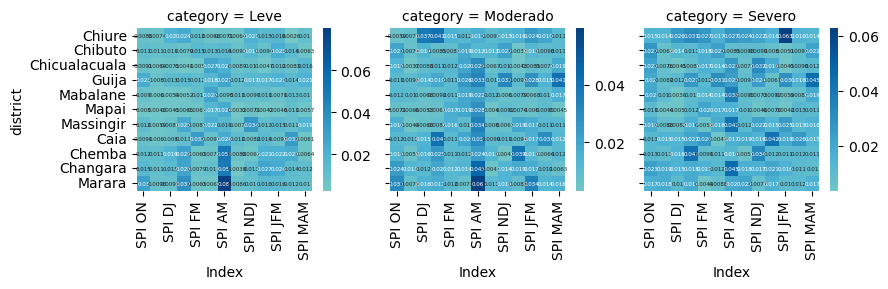

In [140]:
x_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="Index", values="difference2")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['Index', 'district', 'category']).mean('issue').apply(np.sqrt).reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='GnBu', center=0)